# Task 2: Metric Rectification

After having manually selected the more useful features, rectify (reconstruct up to a similarity) the horizontal section of the building. In particular, determine the ratio between the width of facade 2 and the width of facade 3.

## Overview

In this notebook, we will tackle the problem of rectifying the horizontal section of a picture of Villa Melzi d'Eril. To do so, we will perform a stratified rectification, first removing the projective part of the transformation and recovering the original image up to affinity, then by removing the affine transformation and recovering the original image up to a similarity. <br>
To perform the first step, we will identify two sets of parallel lines in the horizontal plane, we will use them to identify the vanishing points and then we will use the vanishing points to estimate the equation of the line at infinity. After having estimated the line at infinity, we will deduce a transformation that maps it back to its original position, thus obtaining the matrix that we will use to perform the affine rectification. <br>
After this step, we will identify two pairs of lines perpendicular to each other, and also exploit a known angle (known because we know the coordinates of the sun) to then deduce how to revert the affine transformation on the image and get the original image, up to a similarity.

In [241]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

image = cv2.imread(f"data/villa.png")[:, :, ::-1]

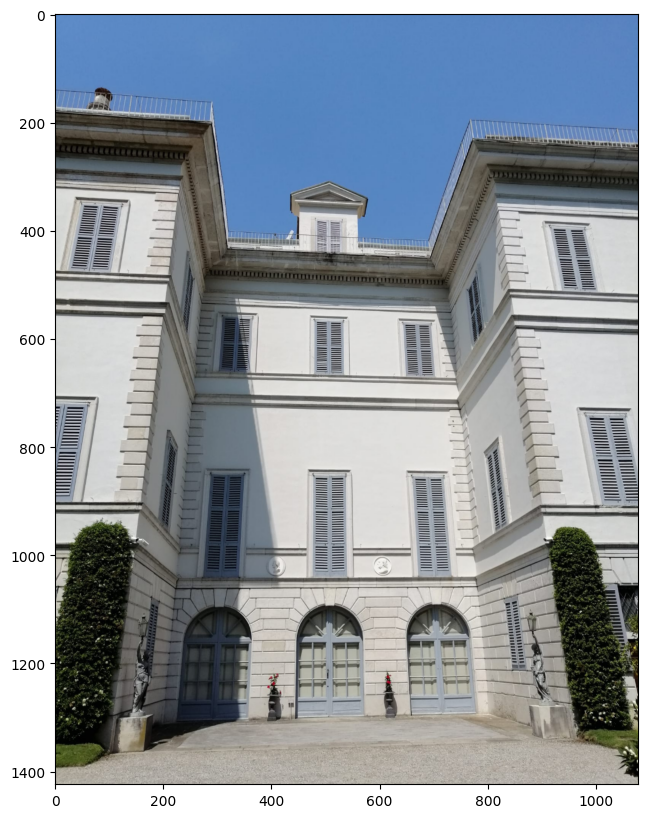

In [242]:
plt.imshow(image)

In the following section, we implement some functions to speed up the selection and visualization of points and lines on the image.

In [243]:
# Function useful to immediately visualize points on the image

def plot_points_with_labels(image, points, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title('Image with Points')
    ax.axis('on')  

    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    for i, point in enumerate(points):
        label = i
        ax.plot(point[0], point[1], color='red', marker='o', markersize=3, label=label)
        ax.annotate(label, (point[0], point[1]), textcoords="offset points", xytext=(5,5), ha='center', color='red')
    
    if ax is None:
        plt.show()


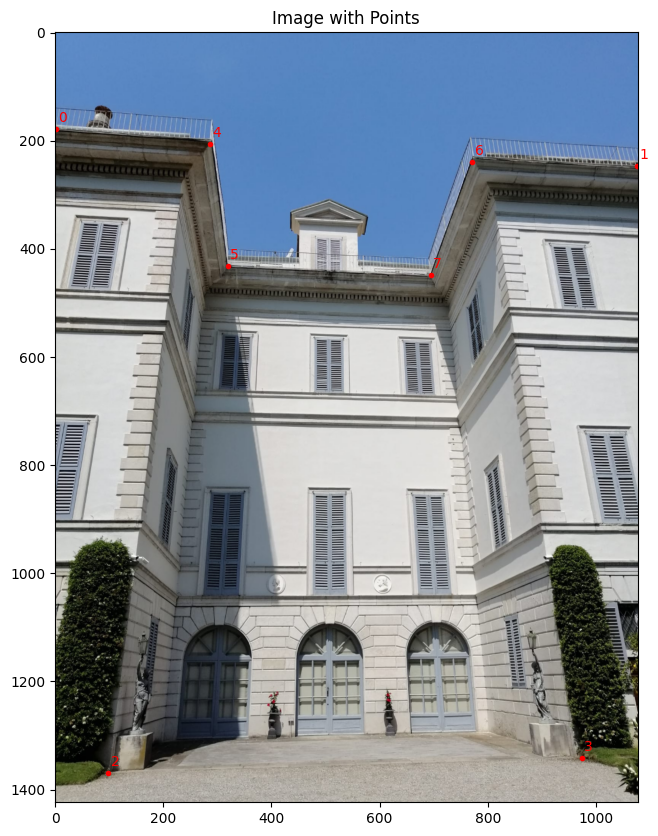

In [244]:
# Example use of the previous function

coordinates = np.loadtxt('coordinates/2024_04_07_20_33_49.txt')
plot_points_with_labels(image, coordinates)

In [245]:
# Function to get line equation in standard form from 2 points
def get_lines(coordinates, list_of_couples):
    return [np.cross(coordinates[point1], coordinates[point2]) for point1, point2 in list_of_couples]

In [246]:
# Function to plot a set of lines and points on the image

def plot_lines(image, points, lines):
    fig, ax = plt.subplots()
    plot_points_with_labels(image, points, ax=ax) 
    
    for point1, point2 in lines:
        ax.plot([points[point1, 0], points[point2, 0]], [points[point1, 1], points[point2, 1]])
    
    plt.show()



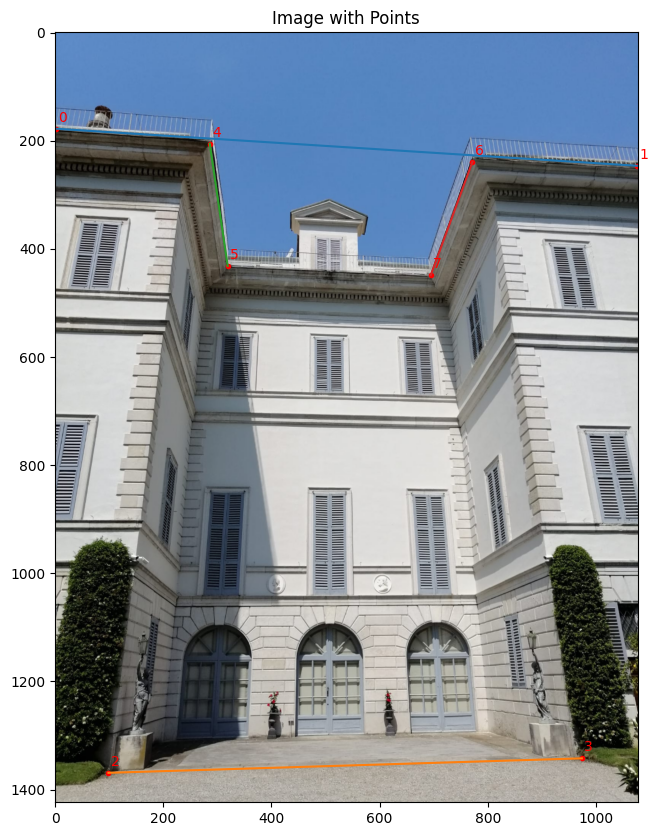

In [247]:
# Example usage

line_endpoints = [[0, 1],
                  [2, 3],
                  [4, 5],
                  [6, 7]
]
plot_lines(image, coordinates, line_endpoints)

In [248]:
# Functions to calculate the ratio between two segments, defined between some points.

def euclidean_dist(point1 , point2):
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calculate_ratio(coordinates, lines):
    lenght1 = euclidean_dist(coordinates[lines[0][0]], coordinates[lines[0][1]])
    lenght2 = euclidean_dist(coordinates[lines[1][0]], coordinates[lines[1][1]])
    return lenght1/lenght2



## First Step: Affine Rectification

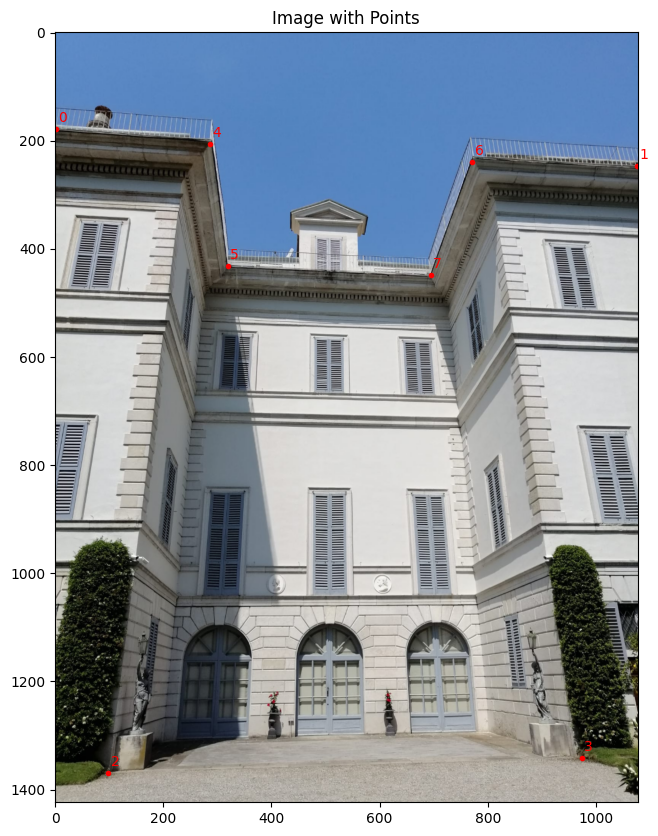

In [249]:
plot_points_with_labels(image, coordinates)

In [250]:
line_endpoints = [[0,1], [2,3], [4,5], [6,7]]
lines = get_lines(coordinates, line_endpoints)

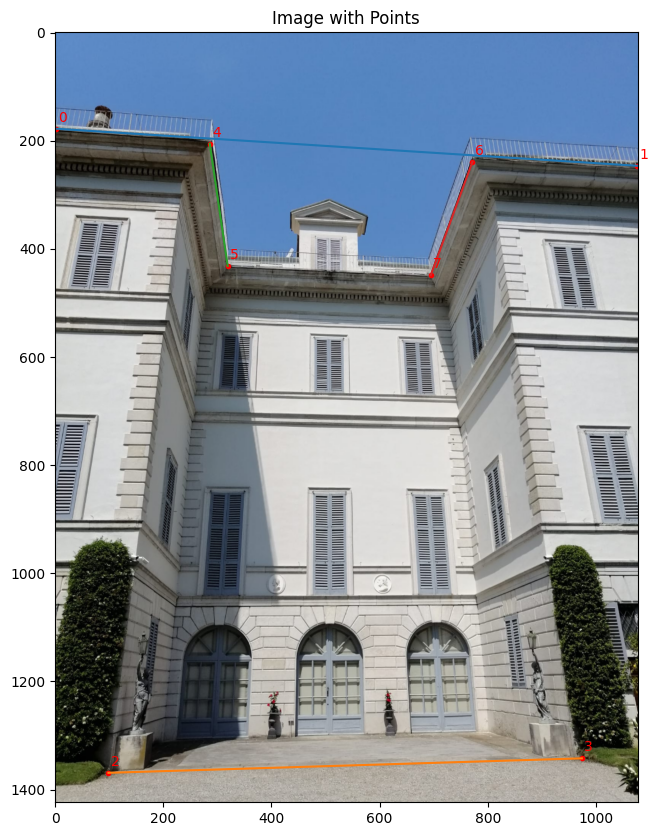

In [251]:
plot_lines(image, coordinates, line_endpoints)

The lines we selected to perform the rectification are the ones that can be seen on the picture. More specifically, we have:
- Line01 and Line23 (parallel to y axis)
- Line45 and Line67 (parallel to z axis)

In the next cell, we estimate the vanishing points and show where they are located with respect to the image


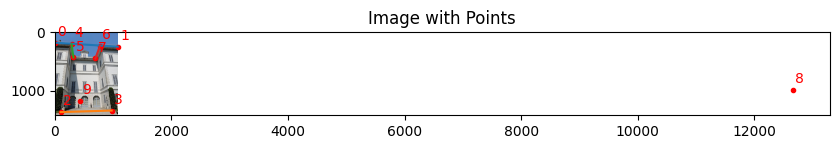

In [252]:
v1 = np.cross(lines[0], lines[1])
v2 = np.cross(lines[2], lines[3])

v1 = v1/v1[-1]
v2 = v2/v2[-1]

augmented_coordinates = np.vstack((coordinates, v1, v2))
lines
plot_lines(image, augmented_coordinates, line_endpoints)

In [253]:
horizon = np.cross(v1,v2)
horizon = horizon/np.linalg.norm(horizon) 

H = np.hstack([np.eye(2),np.zeros((2,1))])
H = np.vstack([H,horizon])

H = H/H[-1,-1]

print(f"New Coordinates of the Line at infinity: \n{np.linalg.inv(H).T@horizon.reshape((-1,1))}")

New Coordinates of the Line at infinity: 
[[ 2.96983629e-22]
 [-4.29386504e-20]
 [ 9.99999641e-01]]


As we can see, after estimating H, we were able to map the line at infinity from the position it had on the projective plane, back to being at infinity. We can therefore exploit the same matrix to map the image back to its form before the projective component of the transformation was applied. <br>
In the next cell, we undo the projective transformation and get back the original image up to affinity.

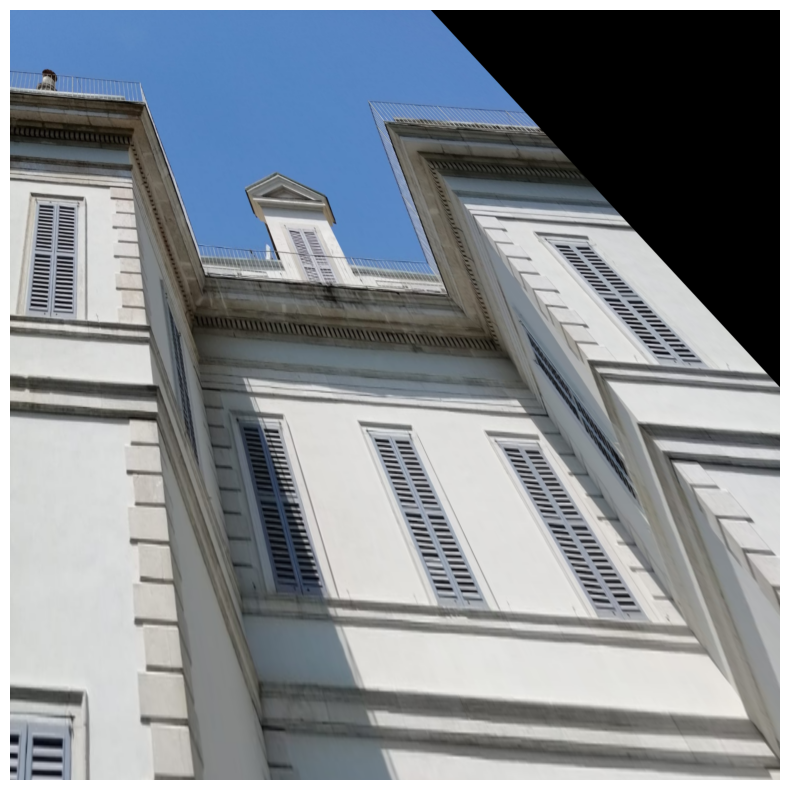

In [254]:
rectified_img = cv2.warpPerspective(image, H, dsize = (2000, 2000))
plt.figure(figsize=(10,10))
plt.imshow(rectified_img)
plt.axis('off')
plt.show()


# STEP 2: Metric Rectification

In this section, we again hand select some points, this time on the newly obtained affinely rectified image. <br>
This time, we need to select some points from which to obtains some pairs of perpendicular lines. Moreover, we also exploit the known relationship between the segments identified in the next image by the points 0_1-1_2 to obtain an extra constraint to better rectify our image

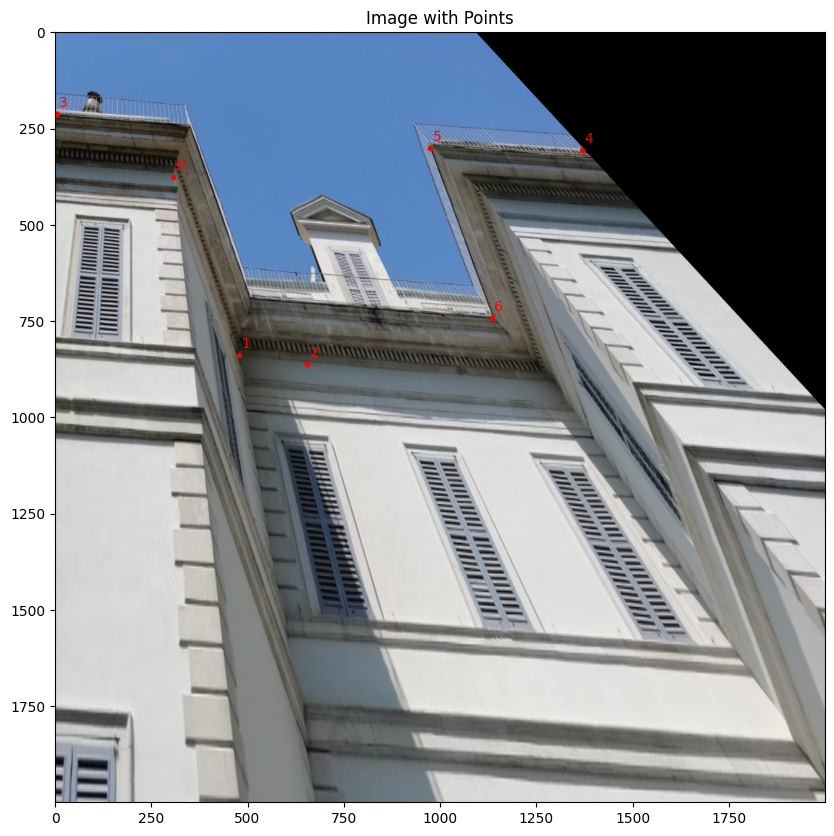

In [255]:
coordinates2 = np.loadtxt('coordinates/2024_04_07_21_01_33.txt')
plot_points_with_labels(rectified_img, coordinates2)

We select the following lines (displayed in the next cell) to build the constraints and perform the rectification:
- Line04, Line56 (they are perpendicular to each other)
- Line01, Line12 (they are perpendicular to each other)
- segment01, segment12 (we know their ratio)

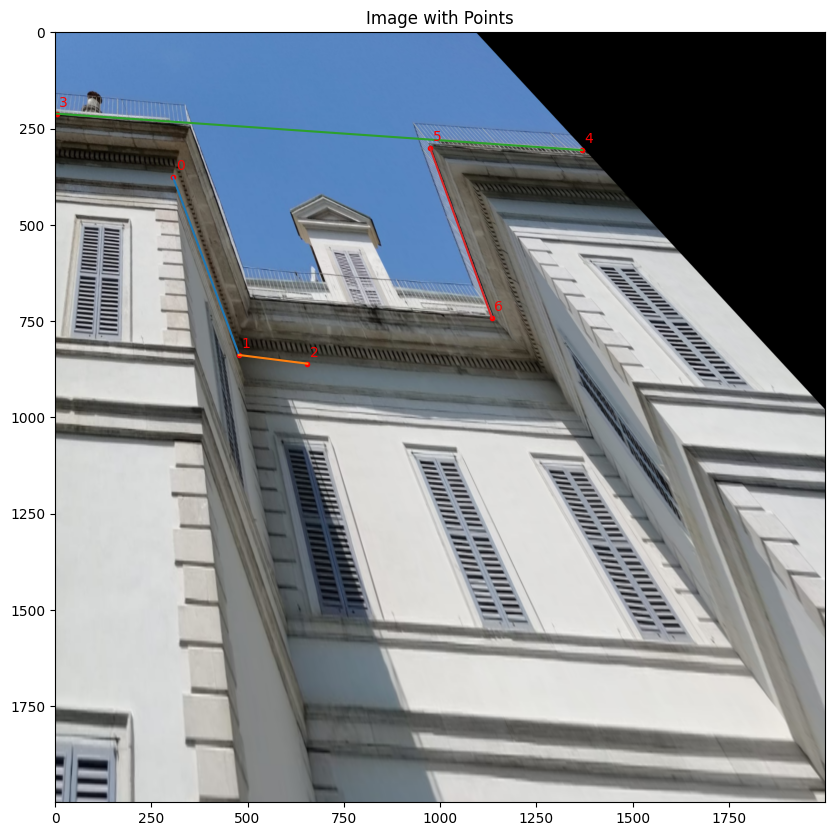

In [256]:
line_endpoints = [[0,1], [1,2], [3, 4], [5, 6]]

lines = get_lines(coordinates2, line_endpoints)
plot_lines(rectified_img, coordinates2, line_endpoints)

In [257]:
line_pairs = [[lines[0], lines[1]], [lines[2], lines[3]]]

A = np.zeros((len(line_pairs) + 1, 3))

l = line_pairs[0][0]
m = line_pairs[0][1]
k = (1/3.9)**2  # Ratio obtained by the position of the sun, and the shadow cast by facade 2 on facade 3

# First 2 contraints: pairs of perpendicular lines
for i, (l, m) in enumerate(line_pairs):

    l /= np.linalg.norm(l)
    m /= np.linalg.norm(m)
    A[i] = [
        l[0]*m[0],
        l[0]*m[1]+l[1]*m[0],
        l[1]*m[1]
    ]

# Third constraint: known ratio between segments
A[len(line_pairs)] = [m[0] * m[0] - k*l[0]*l[0],
    m[0] * m[1] - k*l[1] * l[0],
    m[1]*m[1] - k*l[1]*l[1]]

_, _, vt = np.linalg.svd(A)
s1,s2,s3 = vt[-1]
S = np.array([[s1, s2/2],
                   [s2/2, s3]])
imDCCP = np.zeros((3,3))
imDCCP[:-1,:-1] = S

In [258]:
u,d,vt = np.linalg.svd(imDCCP)
d[-1] = 1
A = u@np.diag(np.sqrt(d))@vt
C = np.eye(3)
C[-1,-1] = 0
H = np.linalg.inv(A)
H = H/np.linalg.norm(H)
H /= H[2, 2]

print(H)



[[-1.2137062   0.1407407  -0.        ]
 [ 0.1407407  -1.27269753 -0.        ]
 [ 0.          0.          1.        ]]


As we can see, we obtained the matrix corresponding to the affine transformation.

In [259]:
# Code to map the new image back to the origin of the reference system

height, width = rectified_img.shape[:-1]
img_corners = np.array([[0, 0, 1.], [0, height, 1], [width, height, 1], [
                            width, 0, 1]])
mapped_img_corners = img_corners@H.T
mapped_img_corners = mapped_img_corners/mapped_img_corners[:,None,-1]

min_x, min_y, _ = np.floor(np.min(
    mapped_img_corners, axis=0)).astype(np.int64)
max_x, max_y, _ = np.ceil(np.max(
    mapped_img_corners, axis=0)).astype(np.int64)

canvas_height = max_y-min_y
canvas_width = max_x-min_x
dsize = (canvas_width, canvas_height)


mapped_origin =  np.array([min_x,min_y])
print(mapped_origin)
translation = np.eye(3)
translation[:-1, -1] = -mapped_origin
H = H/H[-1, -1]

H = translation@H


[-2428 -2546]


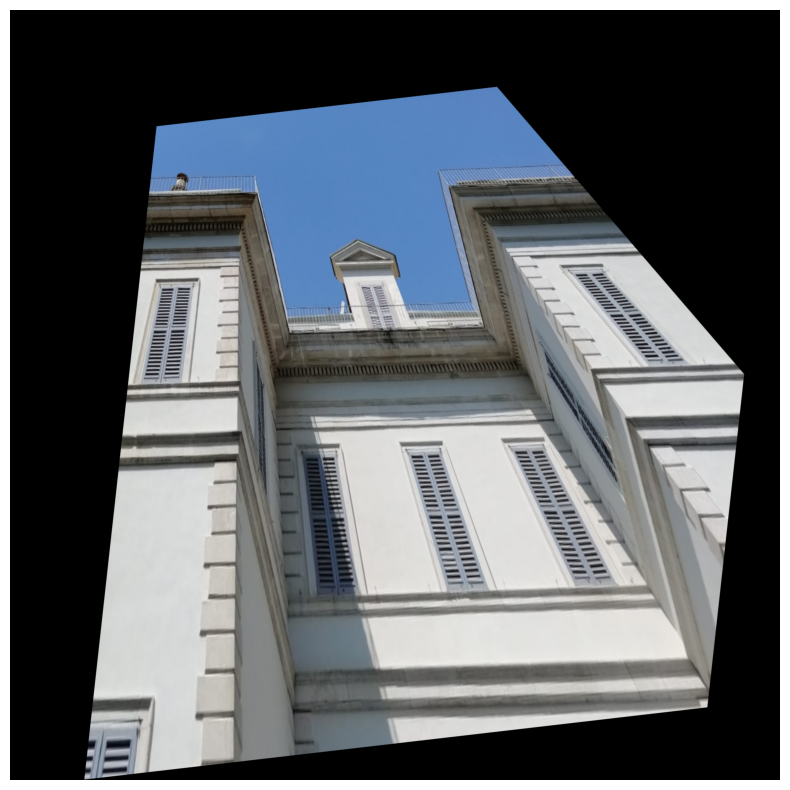

In [260]:
final_image = cv2.warpPerspective(rectified_img,H, dsize = (3000, 3000))
final_image = np.rot90(final_image, k=2)
plt.axis('off')
plt.imshow(final_image)


As we can see, we have now rectified the horizontal section of the image. We can clearly see that facade 2 and 4 are now perfectly perpendicular to facade 3, as can also be seen by the precise square drawn by the edges of the roof.

In [261]:
cv2.imwrite('final_image.png', final_image)

True

In [262]:
new_c = np.loadtxt('coordinates/2024_04_07_22_05_40.txt')[2:]

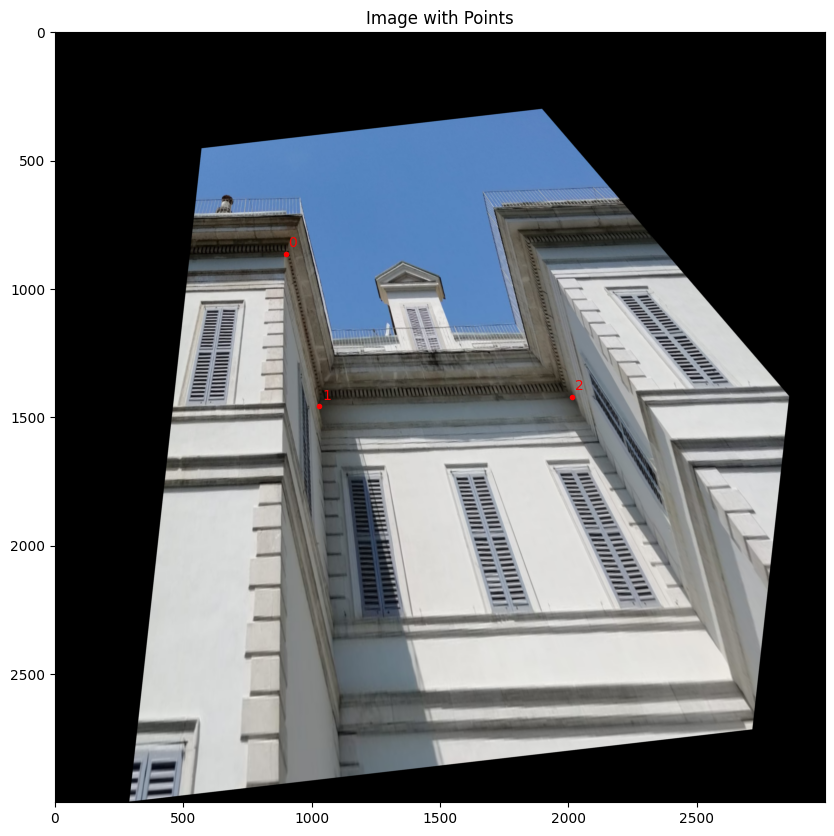

In [263]:
plot_points_with_labels(final_image, new_c)

In [264]:
print(f'Ratio Between Facade 2 and Facade 3: {calculate_ratio(new_c, [[0, 1], [1, 2]]):.2f}')

Ratio Between Facade 2 and Facade 3: 0.62


# Conclusion

In conclusion, we were able to rectify the original section of the image of Villa Melzi d'Eril up to a similarity. Furthermore, we were able to measure the ratio between the width of facade 2 and facade 3, which we estimated to be 0.62. 